Most of the codes below are sourced from this [notebook][1] by [cc05][2].

[1]: https://www.kaggle.com/chenjx1005/physical-meanings-of-technical-20-30
[2]: https://www.kaggle.com/chenjx1005

technical_20 and technical_30 may be the most useful features in this competition.  In this kernel I will investigate what the physical meanings of these two features.

In [1]:
#load libs
import kagglegym
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

env = kagglegym.make()
o = env.reset()
col = [c for c in o.train.columns if '_' in c]

full_df = pd.read_hdf('../input/train.h5')
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * np.sqrt(abs(R2))
    return(R)
pd.options.mode.chained_assignment = None  # default='warn'

we choose one random asset id, and plot the technical_20 - y curve. For better visualization, we scale the technical_20 values.

1561


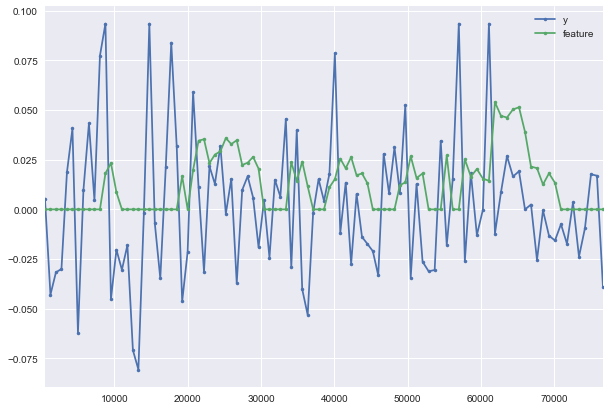

In [2]:
id = 1561 #full_df.id.sample(n=1).iloc[0]  
print(id)
temp = full_df[full_df.id==id]
temp['feature'] = temp['technical_20']
temp['feature'] = temp['feature'] * 4
temp[['y', 'feature']].iloc[:100,:].plot(marker='.', figsize=[10,7])


Y values vibrates strongly. In this figure it is hard for us to find a clear relation between technical_20 and y. We try the cumsum of y values.

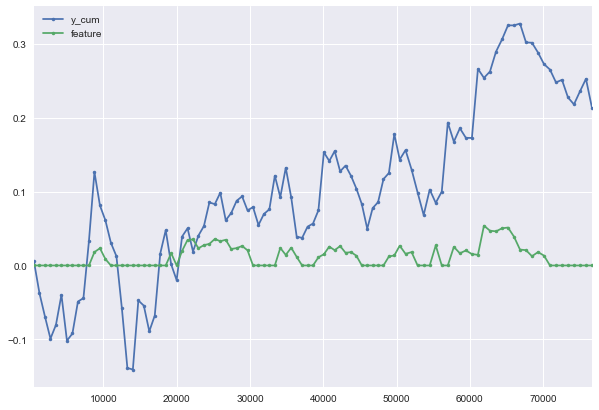

In [3]:
temp['y_cum'] = temp.y.cumsum()
temp[['y_cum', 'feature']].iloc[:100,:].plot(marker='.', figsize=[10,7])

Now we can find something interesting. When the price of the asset increase, technical_20 becomes positive, otherwise technical_20 is zero. Similar relation between technical_30 and cum_sum of y can be found, while it is negative correlation. So we may guess technical_20 may indicate the increase of the price.

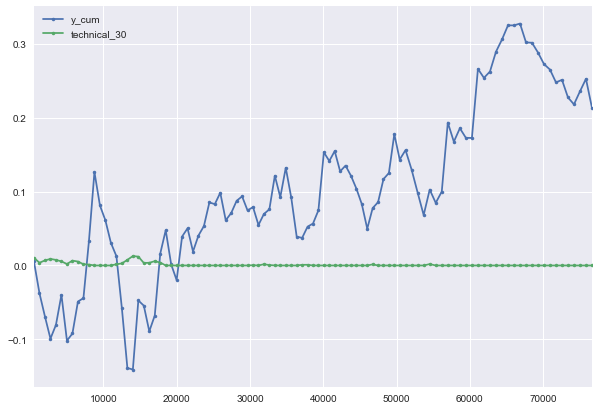

In [4]:
temp[['y_cum', 'technical_30']].iloc[:100,:].plot(marker='.', figsize=[10,7])

We quickly check whether the correlation between techical_20 and y is positive as we observed.

In [5]:
print(np.correlate(temp['y'][~temp['technical_20'].isnull()], temp['technical_20'][~temp['technical_20'].isnull()]))
print(np.correlate(temp['y'][~temp['technical_20'].isnull()], temp['technical_30'][~temp['technical_20'].isnull()]))

[-0.00031708]
[ 0.00022395]


It is weird. The true correlation between y and technical_20 is negative. 

Follow the method in https://www.kaggle.com/achalshah/two-sigma-financial-modeling/linear-regression-lb-0-0091176, we quickly implement a linear regression using technical_20. 

In [6]:
train_data = o.train
cols = 'technical_20'

low_y_cut = -0.086093
high_y_cut = 0.093497

y_values_within = ((train_data['y'] > low_y_cut) & (train_data['y'] <high_y_cut))

train_cut = train_data.loc[y_values_within,:]

# Fill missing values
mean_vals = train_cut.mean()
train_cut.fillna(mean_vals,inplace=True)

x_train = train_cut[cols]
y = train_cut["y"]

lr_model = LinearRegression()
lr_model.fit(np.array(x_train.values).reshape(-1,1),y.values)

val_set = full_df[full_df.timestamp>=906]
x_val = val_set[cols].fillna(mean_vals[cols])
pred = lr_model.predict(x_val.values.reshape(-1, 1))
re = get_reward(val_set['y'], pred)
print("Public score: {}".format(re))
print("learned parameter of the model: {}".format(lr_model.coef_))

Public score: 0.0169169661847
learned parameter of the model: [-0.15299046]


The coefficients is negative. Carefully exam the the technical_20 - y curve, we may find that technical_20 looks like the lag of the y value.  To verify this hypothesis, we use t day's technical_20 to predict t-1 day's y.

In [7]:
train_cut = train_data.loc[y_values_within,:]
x_train = train_cut.groupby('id')[cols].shift(-1).fillna(mean_vals[cols])
y = train_cut["y"]

lr_model2 = LinearRegression()
lr_model2.fit(np.array(x_train.values).reshape(-1,1),y.values)

x_val = val_set.groupby('id')[cols].shift(-1).fillna(mean_vals[cols])
pred = lr_model2.predict(x_val.values.reshape(-1, 1))
re = get_reward(val_set['y'], pred)
print("Public score: {}".format(re))
print("learned parameter of the model: {}".format(lr_model2.coef_))

Public score: 0.260821468883
learned parameter of the model: [ 1.64376569]


Wow, the public score is 0.26. Such a high score indicate that technical_20 is derived from t-1 day's y value.  Since technical_20 relates to the increase while technical_30 relates to the decrease, we construct a new feature technical_20-30 using technical_20 minus technical_30. With the help of Linear Regression, we use previous days' y values estimate this feature and investigate the physical meanings.

In [8]:
temp = full_df.copy()
temp['feature'] = temp['technical_20'] - temp['technical_30']
n = 5
for i in range(1, n+1):
    temp['fea_%d'%i] = temp.groupby('id')['y'].shift(i)
temp = temp.filter(regex='^fea').dropna()
estimator = LinearRegression()
estimator.fit(temp.filter(regex='^fea_').values, temp.feature.values)
#temp['pred_f'] = eastimator.predict(temp.filter(regex='^fea_').fillna(mean_vals).values)
print(estimator.intercept_, estimator.coef_)

(0.00014360806543632301, array([ 0.06922239,  0.06366348,  0.05833867,  0.05318845,  0.04781542]))


We choose another id and see out-of-sample fitting result

142


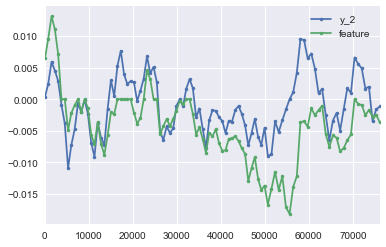

In [9]:
id = 142 #full_df.id.sample().values[0]
print(id)
temp = full_df[full_df.id==id]
temp['feature'] = temp['technical_20'] - temp['technical_30']
mean_vals = temp.y.mean()
for i in range(1, n+1):
    temp['fea_%d'%i] = temp['y'].shift(i)
temp['y_2'] = estimator.predict(temp.filter(regex='^fea_').fillna(mean_vals).values)
temp[['y_2', 'feature']].iloc[:100,:].plot(marker='.')

The estimated feature roughly looks like the true features. And from the coefficients of estimator, we can guess 20-30 is a kind of moving average the y values. We use more y values to predict feature.

(5.7791436817702252e-05, array([ 0.06911024,  0.06370532,  0.05868763,  0.05390181,  0.04941771,
        0.04538222,  0.04167264,  0.03830543,  0.03509727,  0.03224535,
        0.02948497,  0.02703384,  0.0248101 ,  0.02254017,  0.02038287,
        0.0187188 ,  0.01710867,  0.0158317 ,  0.01470537,  0.01309994]))


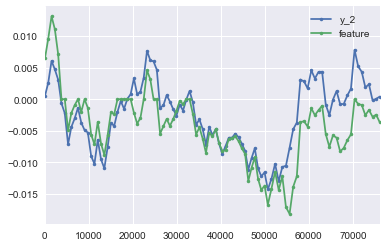

In [10]:
temp = full_df.copy()
temp['feature'] = temp['technical_20'] - temp['technical_30']
n = 20
for i in range(1, n+1):
    temp['fea_%d'%i] = temp.groupby('id')['y'].shift(i)
temp = temp.filter(regex='^fea').dropna()
estimator = LinearRegression()
estimator.fit(temp.filter(regex='^fea_').values, temp.feature.values)
#temp['pred_f'] = eastimator.predict(temp.filter(regex='^fea_').fillna(mean_vals).values)
print(estimator.intercept_, estimator.coef_)

id = 142 #full_df.id.sample().values[0]
temp = full_df[full_df.id==id]
temp['feature'] = temp['technical_20'] - temp['technical_30']
mean_vals = temp.y.mean()
for i in range(1, n+1):
    temp['fea_%d'%i] = temp['y'].shift(i)
temp['y_2'] = estimator.predict(temp.filter(regex='^fea_').fillna(mean_vals).values)
temp[['y_2', 'feature']].iloc[:100,:].plot(marker='.')

When we use more y values, the estimated feature is more accurate. So we can say technical_20 and technical_30 is a kind of weighted moving mean of historical y values, and nearer y values have larger weights.  Now we try to how these weights shrink.

In [11]:
for i in range(len(estimator.coef_)-1):
    print(estimator.coef_[i+1]/estimator.coef_[i])

0.921792781856
0.921236042877
0.918452527326
0.916809936944
0.918339167278
0.918259079212
0.919198584926
0.916248084738
0.918742350488
0.91439435495
0.91686851398
0.917742237979
0.908507765759
0.904291150955
0.918359191485
0.913983552344
0.925361036604
0.928856064518
0.890826852397


It seems the shrink scale is around 0.92. Denote technical_20-30 as F, So we assume F(t) = 0.08* y(t-1) + 0.92 * F(t-1). Have a quick verification.

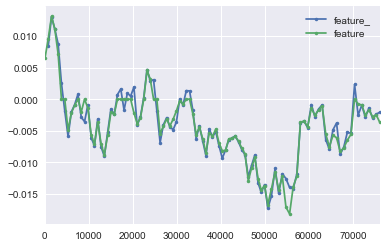

In [12]:
temp['feature_'] = 0.08 * temp['fea_1'] + 0.92 * temp['feature'].shift(1)
temp[['feature_', 'feature']].iloc[:100,:].plot(marker='.')

bravo! The hypothetical feature curve is very close to the true curve. So we can confirm that the feature comes in this way.  However, as we see before, the technical_20, and technical_30 are clipped to a lower bound 0, so in some case, the curve will be not exactly same as we assume, especially when 0 appears frequently.  For example:

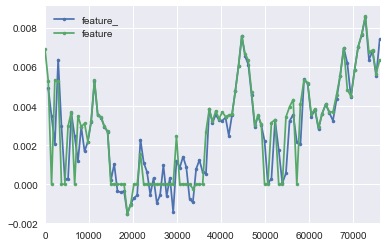

In [13]:
id = 12 #full_df.id.sample().values[0]
temp = full_df[full_df.id==id]
temp['feature'] = temp['technical_20'] - temp['technical_30']
temp['feature_'] = 0.07 * temp['y'].shift(1) + 0.92 * temp['feature'].shift(1)
temp[['feature_', 'feature']].iloc[:100,:].plot(marker='.')